#### Summary:
I'll be using this notebook to prepare the inputs for Scrublet (MM files) and also analyze the outputs ontop of the previous UMAPs, compare list overlaps, etc.

In [11]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
Sys.setenv(RETICULATE_PYTHON="/home/hmummey/.conda/envs/reticulate_v2/bin/python")
library(reticulate)
reticulate::use_python("/home/hmummey/.conda/envs/reticulate_v2/bin/python")
reticulate::use_condaenv("/home/hmummey/.conda/envs/reticulate_v2")
#reticulate::py_module_available(module='leidenalg') #needs to be TRUE
#reticulate::import('leidenalg') #good to make sure this doesn't error

In [12]:
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(future))

In [13]:
suppressMessages(library(tictoc))
suppressMessages(library(plyr))
suppressMessages(library(enrichR))
suppressMessages(library(stringr))
suppressMessages(library(ggrepel))

# Exporting RDS Objects as MM files for Scrublet

#### Example code from 211117_Generate_RNA_CellType_Profiles

In [ ]:
#for each cell type: pull out raw counts matrix, cut down by cell type, cut down by
#gene list, export

for (cell.type in unique_cell_types){
    print(paste(cell.type,Sys.time()))
    #pull out counts for cells in the cell type
    bcs <- names(Idents(adata)[Idents(adata) == cell.type])
    ct.counts <- gex.counts[,colnames(gex.counts) %in% bcs]
    dim(ct.counts)

    #read in gene list from file
    exp.fp1 <- file.path(out_dir,sprintf('R207_%s_expressed_genes.txt',cell.type))
    ct.genes <- scan(exp.fp1, what="", sep="\n")
    length(ct.genes)
    #head(ct.genes)

    #cut down to just genes from expressed genes list
    ct.counts.cut <- ct.counts[row.names(ct.counts) %in% ct.genes,]
    dim(ct.counts.cut)
    
    #export this as a matrix market file 
    #(more space efficient than converting to df and writing to csv)
    mm.fp <- file.path(out_dir,sprintf('R207_%s_expressed_genes_raw_counts.txt',cell.type))
    writeMM(ct.counts.cut,mm.fp)
    
    #also export BCs list
    bc.fp <- file.path(out_dir,sprintf('R207_%s_BCs.txt',cell.type))
    write(bcs,bc.fp,sep='\n')
}

In [22]:
outdir = "/nfs/lab/hmummey/multiomic_islet/intermediates/220720_multiome_clustering_redo"
rds_fp1 = file.path(outdir,'220818_31sample_50kHVWs_combined.noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.rds')
rds_fp2 = file.path(outdir,"220720_31sample_50kHVWs_combined.noAMULET.rds")
rds_fp3 = "/nfs/lab/hmummey/multiomic_islet/intermediates/211016_combined_clusters_cleaning/31sample_VariableFeature_HVWs_combined.rds"
rds_fp4 = "/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/R207/final_filtered.rds"

### Post MT and TSSe < 2, ATAC+RNA Upper Bounds Object

In [11]:
output_prefix <- 'noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds'
output_dir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot'

In [13]:
source(sprintf('mkdir -p %s',file.path(output_dir,output_prefix)))
#just manually made this LOL

Warning message in file(filename, "r", encoding = encoding):
"cannot open file 'mkdir -p /nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds': No such file or directory"


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [7]:
#read in RDS file
tic()
adata = readRDS(rds_fp1)
toc()

339.154 sec elapsed


In [14]:
#pull out RNA counts to a separate object
DefaultAssay(adata) <- 'RNA'
rna.counts <- GetAssayData(adata,slot='counts')
mm.fp <- file.path(output_dir,output_prefix,'matrix.mtx')
tic()
writeMM(rna.counts,mm.fp)
toc()

#also export the gene list (and barcodes just in case)
genes.fp <- file.path(output_dir,output_prefix,'genes.tsv')
write(row.names(rna.counts),genes.fp,sep='\n')

barcodes.fp <- file.path(output_dir,output_prefix,'barcodes.tsv')
write(colnames(rna.counts),barcodes.fp,sep='\n')

NULL

2716.929 sec elapsed


### Raw Combined Object

In [17]:
output_prefix <- 'raw_combined'
output_dir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot'

In [19]:
#source(sprintf('mkdir -p %s',file.path(output_dir,output_prefix)))
#just manually made this dir LOL

In [20]:
#read in RDS file
tic()
adata = readRDS(rds_fp3)
toc()

430.149 sec elapsed


In [21]:
#pull out RNA counts to a separate object
DefaultAssay(adata) <- 'RNA'
rna.counts <- GetAssayData(adata,slot='counts')
mm.fp <- file.path(output_dir,output_prefix,'matrix.mtx')
tic()
writeMM(rna.counts,mm.fp)
toc()

#also export the gene list (and barcodes just in case)
genes.fp <- file.path(output_dir,output_prefix,'genes.tsv')
write(row.names(rna.counts),genes.fp,sep='\n')

barcodes.fp <- file.path(output_dir,output_prefix,'barcodes.tsv')
write(colnames(rna.counts),barcodes.fp,sep='\n')

NULL

3519.485 sec elapsed


### One single sample UMAP

In [23]:
output_prefix <- 'sample_R207'
output_dir <- '/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot'

In [24]:
#source(sprintf('mkdir -p %s',file.path(output_dir,output_prefix)))
#just manually made this dir LOL

In [25]:
#read in RDS file
tic()
adata = readRDS(rds_fp4)
toc()

56.114 sec elapsed


In [26]:
#pull out RNA counts to a separate object
DefaultAssay(adata) <- 'RNA'
rna.counts <- GetAssayData(adata,slot='counts')
mm.fp <- file.path(output_dir,output_prefix,'matrix.mtx')
tic()
writeMM(rna.counts,mm.fp)
toc()

#also export the gene list (and barcodes just in case)
genes.fp <- file.path(output_dir,output_prefix,'genes.tsv')
write(row.names(rna.counts),genes.fp,sep='\n')

barcodes.fp <- file.path(output_dir,output_prefix,'barcodes.tsv')
write(colnames(rna.counts),barcodes.fp,sep='\n')

NULL

140.001 sec elapsed


## Looping through all single samples and writing MM files 
Will output these to a new dir in the the sample `indv_sample_processing` directory.

In [4]:
samples <- c('R207','R217','R218','R221','R223',
             'R226','R228','R234','R237','R238',
             'R246', 'R247', 'R275', 'R277', 'R284', 
             'R290', 'R292', 'R316', 'R317', 'R319',
             'R325','R326','R327','R332','R343',
             'R349','R353','R354','R362','R363','R364')

In [8]:
for (sample in samples){
    print(paste(sample, Sys.time()))
    #set up necessary file structures
    sample_dir <- sprintf("/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s",sample)
    mm_outdir <- file.path(sample_dir,'matrix_market')
    dir.create(mm_outdir)
    
    #read in RDS
    adata <- readRDS(file = file.path(sample_dir,"final_filtered.rds"))
    
    #pull out RNA counts to a separate object and writeMM
    DefaultAssay(adata) <- 'RNA'
    rna.counts <- GetAssayData(adata,slot='counts')
    mm.fp <- file.path(mm_outdir,'matrix.mtx')
    writeMM(rna.counts,mm.fp)
    
    #also export the gene list (and barcodes just in case)
    genes.fp <- file.path(mm_outdir,'genes.tsv')
    write(row.names(rna.counts),genes.fp,sep='\n')

    barcodes.fp <- file.path(mm_outdir,'barcodes.tsv')
    write(colnames(rna.counts),barcodes.fp,sep='\n')
}

[1] "R207 2022-08-25 11:59:34"
[1] "R217 2022-08-25 12:02:55"
[1] "R218 2022-08-25 12:06:10"
[1] "R221 2022-08-25 12:08:01"
[1] "R223 2022-08-25 12:09:46"
[1] "R226 2022-08-25 12:13:02"
[1] "R228 2022-08-25 12:16:00"
[1] "R234 2022-08-25 12:18:36"
[1] "R237 2022-08-25 12:21:33"
[1] "R238 2022-08-25 12:24:23"
[1] "R246 2022-08-25 12:27:13"
[1] "R247 2022-08-25 12:28:09"
[1] "R275 2022-08-25 12:30:32"
[1] "R277 2022-08-25 12:32:15"
[1] "R284 2022-08-25 12:34:51"
[1] "R290 2022-08-25 12:37:05"
[1] "R292 2022-08-25 12:39:55"
[1] "R316 2022-08-25 12:42:40"
[1] "R317 2022-08-25 12:46:24"
[1] "R319 2022-08-25 12:50:43"
[1] "R325 2022-08-25 12:54:43"
[1] "R326 2022-08-25 12:55:32"
[1] "R327 2022-08-25 12:59:36"
[1] "R332 2022-08-25 13:01:56"
[1] "R343 2022-08-25 13:04:40"
[1] "R349 2022-08-25 13:06:15"
[1] "R353 2022-08-25 13:07:39"
[1] "R354 2022-08-25 13:09:55"
[1] "R362 2022-08-25 13:12:06"
[1] "R363 2022-08-25 13:15:12"
[1] "R364 2022-08-25 13:18:28"


# Visualizing and Comparing Scrublet Test Outputs
Methods to visualize these outputs in R:
- Overlay the doublet scores onto the combined UMAPs, then also overlay the doublet decisions (from threshold)
- Overlay the Test 1 doublets on the raw UMAP as well, and compare the doublets in these two lists
- Compare Test 3 doublets with Test 1 and Test 2 doublets from that same sample
- Run Scrublet on all samples and then compare these doublet lists to the other ones

In [ ]:
#sets of scrublet doublet calls
#raw object: /nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/raw_combined.scrublet_predicted_doublets_cutoff0.2.txt
#current filtered object: /nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.scrublet_predicted_doublets_cutoff0.3.txt
#sample objects: /nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/${sample}/matrix_market/scrublet_predicted_doublets_cutoff${something}.txt

#need to combine all the predicted doublets files... not sure if they have sample prefixes on the BCs though
#THEY DON'T, which is fine, I'll read them in, add the prefixes and then concat

In [9]:
samples <- c('R207','R217','R218','R221','R223',
             'R226','R228','R234','R237','R238',
             'R246', 'R247','R275','R277','R284', 
             'R290', 'R292','R316','R317','R319',
             'R325','R326','R327','R332','R343',
             'R349','R353','R354','R362','R363','R364')

In [49]:
fin_scrub_df = data.frame()

for (sample in samples){
    print(c(sample, Sys.time()))
    #get the cutoff number (inefficient but not redoing anything and is at least record keeping)
    outdir = sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s/matrix_market',sample)
    files = list.files(outdir)
    fp = files[grep('scrub',files)]
    cutoff = substr(fp, unlist(gregexpr('cutoff',fp))+6, unlist(gregexpr('.txt',fp))-1)
    print(cutoff)
    
    #read in scrublet file
    scrub_fp = file.path(outdir,sprintf('scrublet_predicted_doublets_cutoff%s.txt',cutoff))
    scrub_df = read.table(scrub_fp, sep='\t', header=FALSE)
    # print(head(scrub_df))
    
    #add on sample BC prefix
    scrub_df$V1 = paste(sample, '_', scrub_df$V1, sep='')
    # print(head(scrub_df))
    
    fin_scrub_df = rbind(fin_scrub_df,scrub_df)
}

out_fp = '/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets.txt'
write.table(fin_scrub_df[,c(1,2,3)],out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)

[1] "R207"             "1661540287.15023"
[1] "0.2557159026533267"
[1] "R217"             "1661540287.18335"
[1] "0.17592480680131617"
[1] "R218"             "1661540287.21962"
[1] "0.5862940832320086"
[1] "R221"             "1661540287.24252"
[1] "0.6329810176769175"
[1] "R223"             "1661540287.26775"
[1] "0.20057109796338418"
[1] "R226"             "1661540287.29133"
[1] "0.21798500551758931"
[1] "R228"             "1661540287.31144"
[1] "0.18229496603578663"
[1] "R234"             "1661540287.33118"
[1] "0.20616746937851066"
[1] "R237"             "1661540287.35326"
[1] "0.21591387236966297"
[1] "R238"             "1661540287.37435"
[1] "0.6315931358627211"
[1] "R246"             "1661540287.39539"
[1] "0.21450430034488194"
[1] "R247"             "1661540287.40824"
[1] "0.206563350297425"
[1] "R275"             "1661540287.42942"
[1] "0.6113444560827188"
[1] "R277"             "1661540287.44952"
[1] "0.6364434959065014"
[1] "R284"             "1661540287.47354"
[1] "0.1780121

### Remaking individual sample Scrublet output doublet list based on redo samples

In [3]:
redo_samples = c('R218','R221','R238','R275', 'R277',
                 'R317', 'R319','R343','R349','R364')

In [4]:
samples <- c('R207','R217','R218','R221','R223',
             'R226','R228','R234','R237','R238',
             'R246', 'R247','R275','R277','R284', 
             'R290', 'R292','R316','R317','R319',
             'R325','R326','R327','R332','R343',
             'R349','R353','R354','R362','R363','R364')

In [6]:
fin_scrub_df = data.frame()

for (sample in samples){
    print(c(sample, Sys.time()))
    #get the cutoff number (inefficient but not redoing anything and is at least record keeping)
    outdir = sprintf('/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s/matrix_market',sample)
    if (sample %in% redo_samples){
        cutoff = '0.25'
        print(cutoff)
    } else {
        files = list.files(outdir)
        fp = files[grep('scrub',files)]
        cutoff = substr(fp, unlist(gregexpr('cutoff',fp))+6, unlist(gregexpr('.txt',fp))-1)
        print(cutoff)    
    }
        
    #read in scrublet file
    scrub_fp = file.path(outdir,sprintf('scrublet_predicted_doublets_cutoff%s.txt',cutoff))
    scrub_df = read.table(scrub_fp, sep='\t', header=FALSE)
    # print(head(scrub_df))
    
    #add on sample BC prefix
    scrub_df$V1 = paste(sample, '_', scrub_df$V1, sep='')
    # print(head(scrub_df))
    
    fin_scrub_df = rbind(fin_scrub_df,scrub_df)
}

out_fp = '/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets2.txt'
write.table(fin_scrub_df[,c(1,2,3)],out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)

[1] "R207"             "1662063138.78032"
[1] "0.2557159026533267"
[1] "R217"             "1662063138.81173"
[1] "0.17592480680131617"
[1] "R218"             "1662063138.86208"
[1] "0.25"
[1] "R221"             "1662063138.88525"
[1] "0.25"
[1] "R223"             "1662063138.91489"
[1] "0.20057109796338418"
[1] "R226"             "1662063138.95066"
[1] "0.21798500551758931"
[1] "R228"             "1662063138.98634"
[1] "0.18229496603578663"
[1] "R234"             "1662063139.05762"
[1] "0.20616746937851066"
[1] "R237"             "1662063139.10211"
[1] "0.21591387236966297"
[1] "R238"             "1662063139.15696"
[1] "0.25"
[1] "R246"             "1662063139.19769"
[1] "0.21450430034488194"
[1] "R247"             "1662063139.24848"
[1] "0.206563350297425"
[1] "R275"             "1662063139.33675"
[1] "0.25"
[1] "R277"            "1662063139.3739"
[1] "0.25"
[1] "R284"             "1662063139.41574"
[1] "0.17801217813100262"
[1] "R290"             "1662063139.46352"
[1] "0.17703093285

## Overlay Scrublet doublets on UMAPs

### Raw combined UMAP POST AMULET REMOVAL
- scrublet on raw combined UMAP
- scrublet on indv samples combined
- scrublet on filtered combined UMAP

In [14]:
#read in raw combined RDS first
# raw_rds_fp = "/nfs/lab/hmummey/multiomic_islet/intermediates/211016_combined_clusters_cleaning/31sample_VariableFeature_HVWs_combined.rds"
raw_rds_fp = "/nfs/lab/hmummey/multiomic_islet/intermediates/220720_multiome_clustering_redo/220720_31sample_50kHVWs_combined.noAMULET.rds"
tic()
adata = readRDS(raw_rds_fp)
toc()
adata

269.99 sec elapsed


An object of class Seurat 
119928 features across 233003 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

scrublet.raw_combined
doublet singlet 
  12839  224857 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGGACCTT-1"
[5] "R207_AAACAGCCAGTTATCG-1" "R207_AAACAGCCATAATCCG-1"

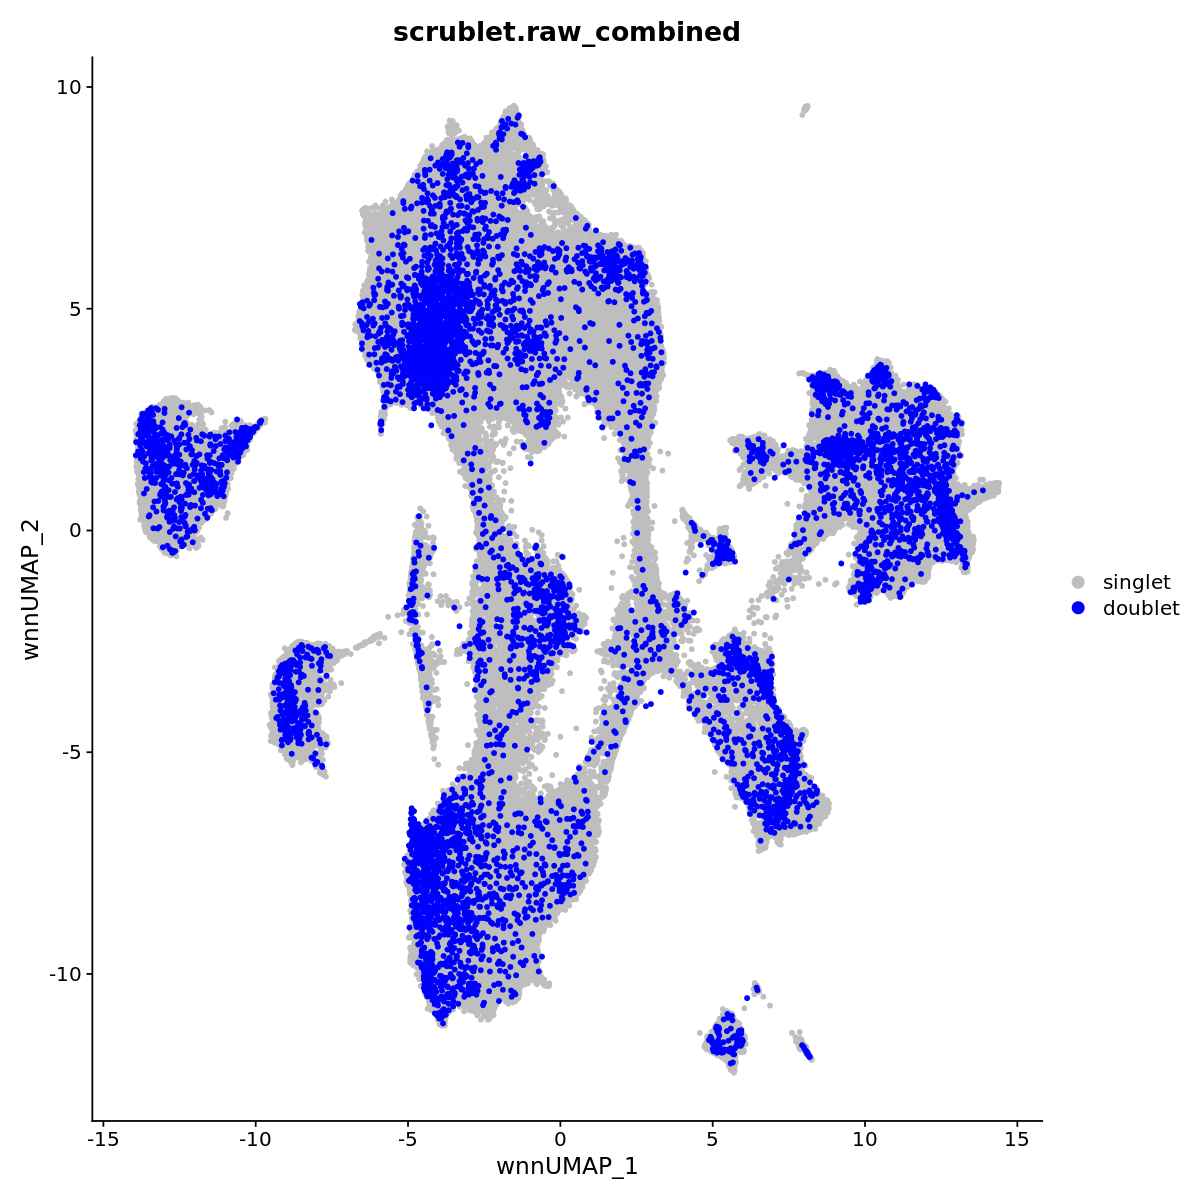

In [15]:
#read in a the first set of scrublet doublets
scrub1 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/raw_combined.scrublet_predicted_doublets_cutoff0.2.txt")
scrub1_doublets = scrub1[scrub1$V2=='True',1]

#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.raw_combined = rep('singlet', length(cells))
names(scrublet.raw_combined) <- cells
scrublet.raw_combined[scrub1_doublets] <- 'doublet'
table(scrublet.raw_combined)
head(names(scrublet.raw_combined))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.raw_combined, col.name='scrublet.raw_combined')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.raw_combined", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

### 9/1/22: redoing this with new indv sample barcodes list

scrublet.raw_indv
doublet singlet 
  11975  225923 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGGACCTT-1"
[5] "R207_AAACAGCCAGTTATCG-1" "R207_AAACAGCCATAATCCG-1"

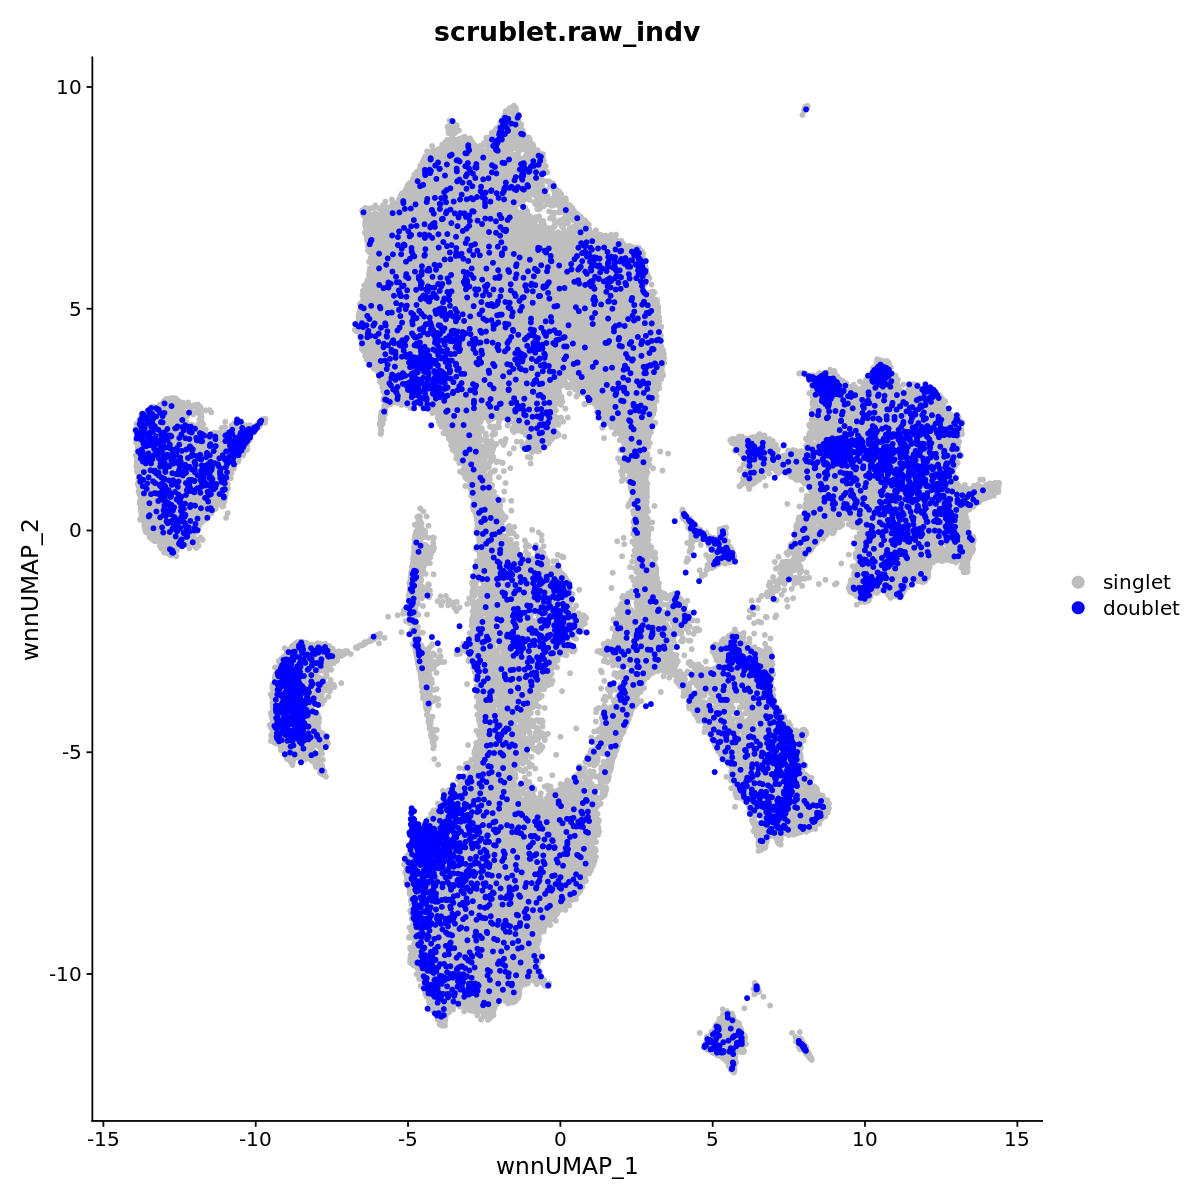

In [16]:
#read in the second set of scrublet doublets
#scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets.txt")
scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets2.txt")

scrub2_doublets = scrub2[scrub2$V2=='True',1]

#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.raw_indv = rep('singlet', length(cells))
names(scrublet.raw_indv) <- cells
scrublet.raw_indv[scrub2_doublets] <- 'doublet'
table(scrublet.raw_indv)
head(names(scrublet.raw_indv))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.raw_indv, col.name='scrublet.raw_indv')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.raw_indv", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

scrublet.filt_comb
doublet singlet 
   4327  228676 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGGACCTT-1"
[5] "R207_AAACAGCCAGTTATCG-1" "R207_AAACAGCCATAATCCG-1"

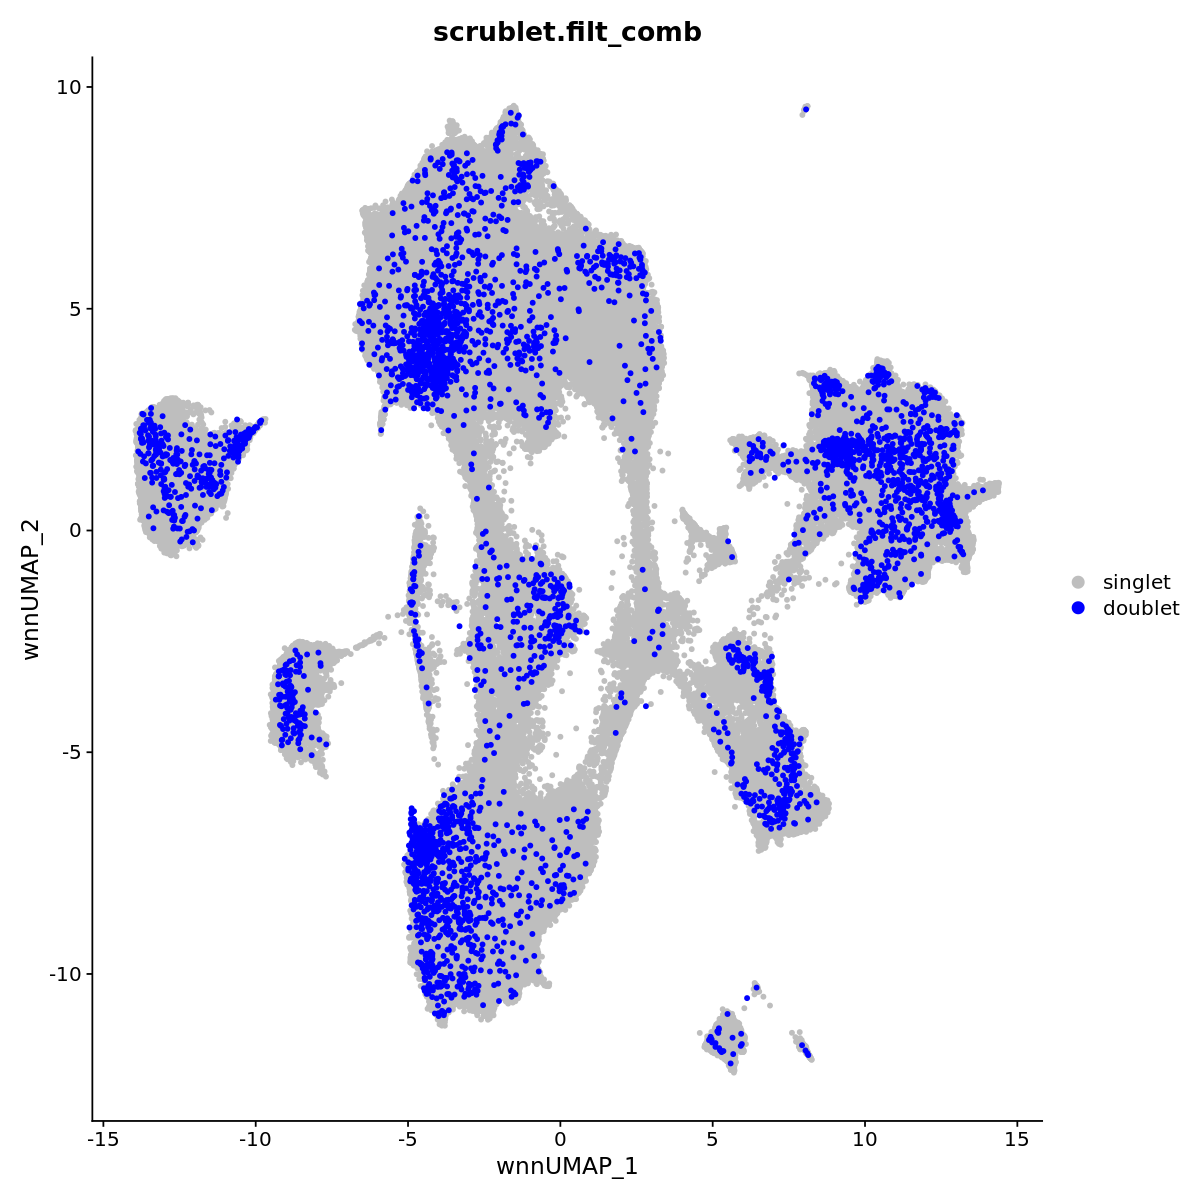

In [66]:
#read in the third set of scrublet doublets
scrub3 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.scrublet_predicted_doublets_cutoff0.3.txt")
scrub3_doublets = scrub3[scrub3$V2=='True',1]

#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.filt_comb = rep('singlet', length(cells))
names(scrublet.filt_comb) <- cells
scrublet.filt_comb[scrub3_doublets] <- 'doublet'
table(scrublet.filt_comb)
head(names(scrublet.filt_comb))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.filt_comb, col.name='scrublet.filt_comb')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.filt_comb", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

### Current filtered combined UMAP 
- scrublet on raw combined UMAP
- scrublet on indv samples combined
- scrublet on filtered combined UMAP

In [17]:
#read in current filtered combined RDS next
filt_rds_fp = "/nfs/lab/hmummey/multiomic_islet/intermediates/220720_multiome_clustering_redo/220818_31sample_50kHVWs_combined.noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.rds"
tic()
adata = readRDS(filt_rds_fp)
toc()
adata

250.705 sec elapsed


An object of class Seurat 
119600 features across 195531 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

[1] 12839

[1] 6323

scrublet.raw_combined
doublet singlet 
   6323  189208 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGTTATCG-1"
[5] "R207_AAACAGCCATAATCCG-1" "R207_AAACAGCCATACCCGG-1"

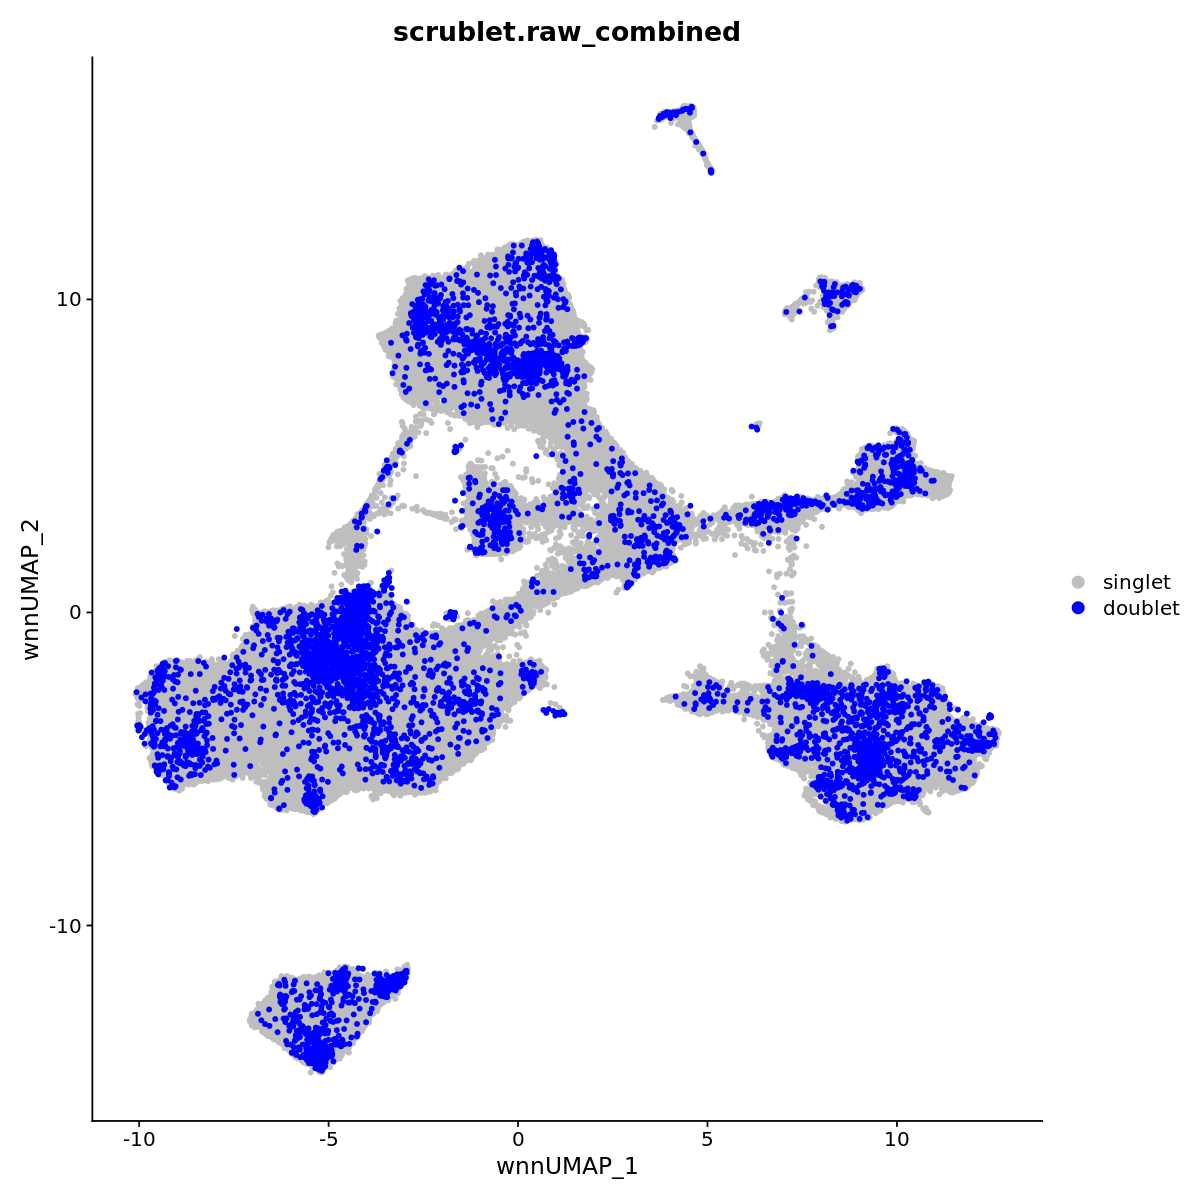

In [73]:
#read in a the first set of scrublet doublets
scrub1 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/raw_combined.scrublet_predicted_doublets_cutoff0.2.txt")
scrub1_doublets = scrub1[scrub1$V2=='True',1]
length(scrub1_doublets)
scrub1_doublets = scrub1_doublets[scrub1_doublets %in% Cells(adata)]
length(scrub1_doublets)


#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.raw_combined = rep('singlet', length(cells))
names(scrublet.raw_combined) <- cells
scrublet.raw_combined[scrub1_doublets] <- 'doublet'
table(scrublet.raw_combined)
head(names(scrublet.raw_combined))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.raw_combined, col.name='scrublet.raw_combined')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.raw_combined", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

### 9/1/22: redoing this with new indv sample barcodes list

[1] 11975

[1] 5100

scrublet.raw_indv
doublet singlet 
   5100  190431 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGTTATCG-1"
[5] "R207_AAACAGCCATAATCCG-1" "R207_AAACAGCCATACCCGG-1"

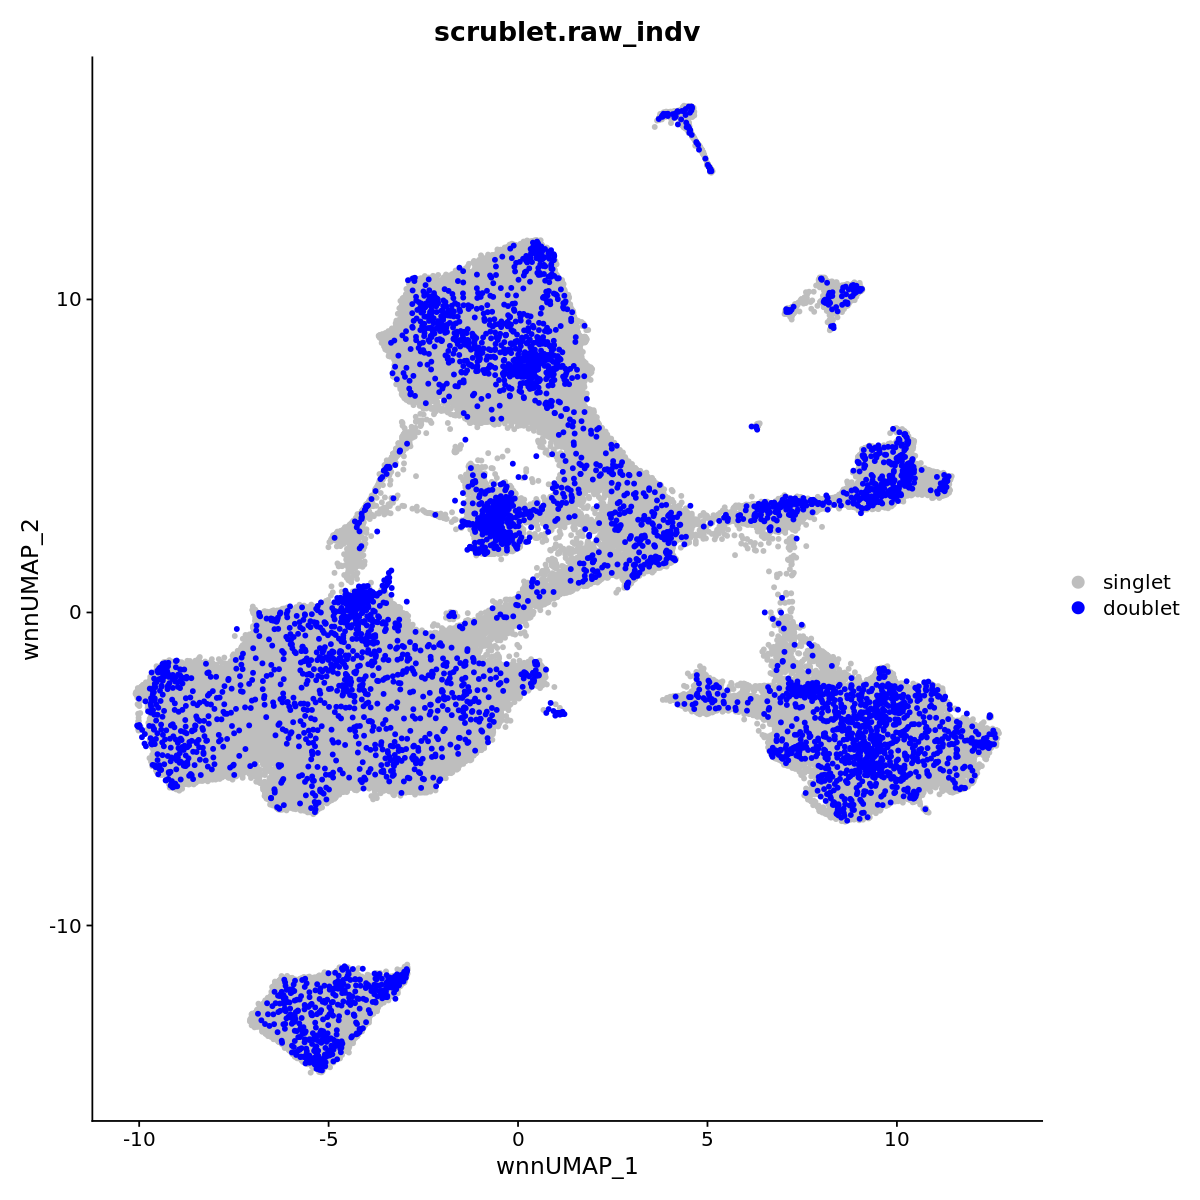

In [18]:
#read in the second set of scrublet doublets
#scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets.txt")
scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets2.txt")

scrub2_doublets = scrub2[scrub2$V2=='True',1]
length(scrub2_doublets)
scrub2_doublets = scrub2_doublets[scrub2_doublets %in% Cells(adata)]
length(scrub2_doublets)


#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.raw_indv = rep('singlet', length(cells))
names(scrublet.raw_indv) <- cells
scrublet.raw_indv[scrub2_doublets] <- 'doublet'
table(scrublet.raw_indv)
head(names(scrublet.raw_indv))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.raw_indv, col.name='scrublet.raw_indv')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.raw_indv", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

[1] 4327

[1] 4327

scrublet.filt_comb
doublet singlet 
   4327  191204 

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGTTATCG-1"
[5] "R207_AAACAGCCATAATCCG-1" "R207_AAACAGCCATACCCGG-1"

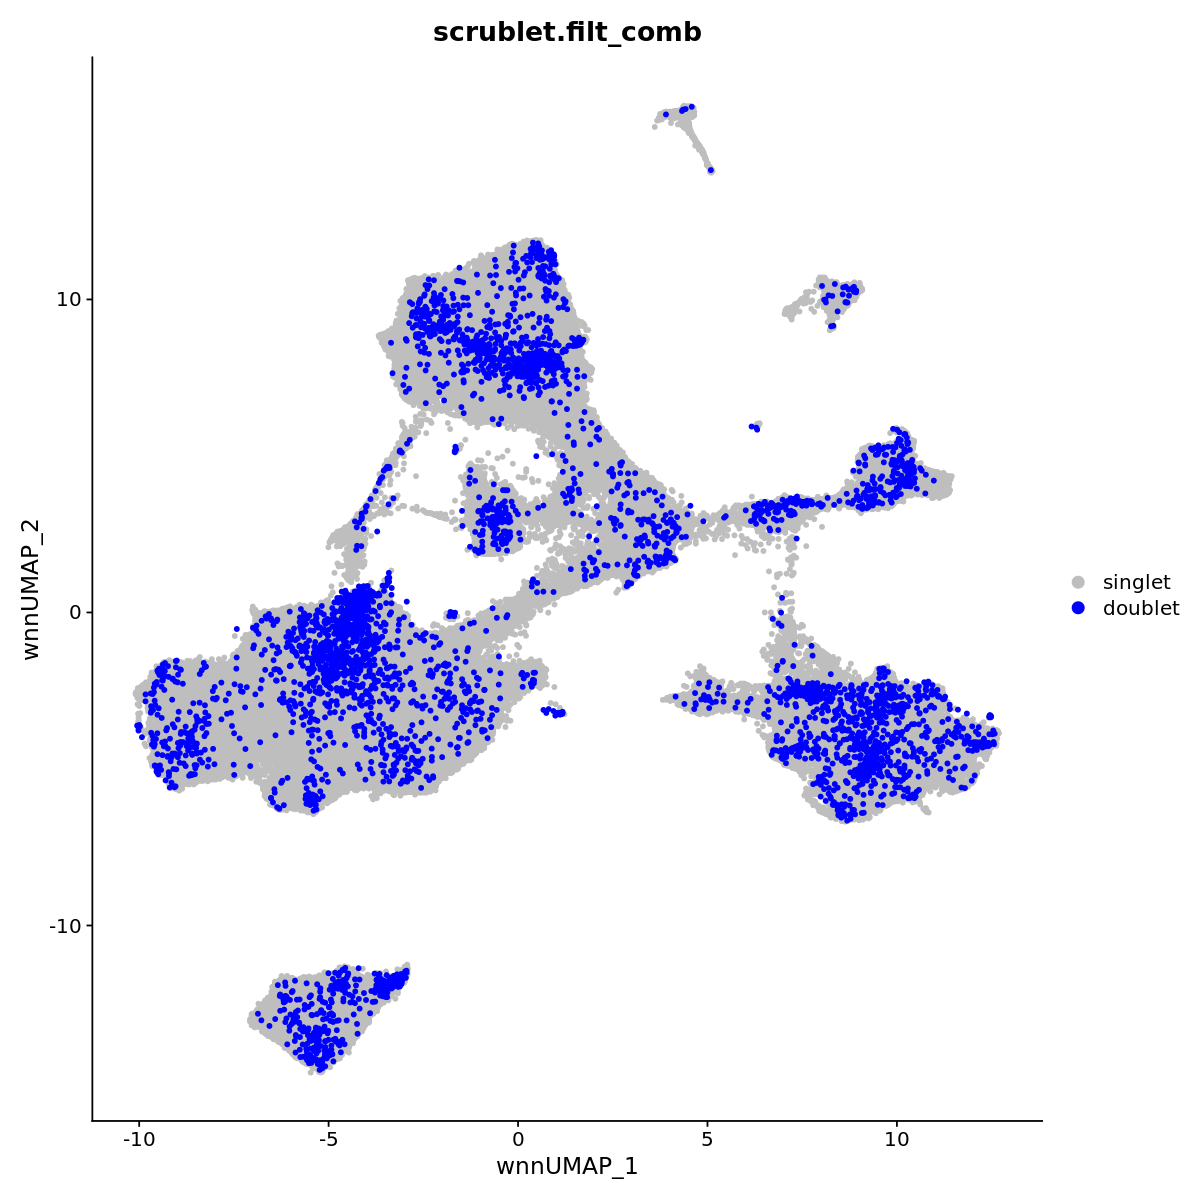

In [75]:
#read in the third set of scrublet doublets
scrub3 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.scrublet_predicted_doublets_cutoff0.3.txt")
scrub3_doublets = scrub3[scrub3$V2=='True',1]
length(scrub3_doublets)
scrub3_doublets = scrub3_doublets[scrub3_doublets %in% Cells(adata)]
length(scrub3_doublets)


#create vector of assignments with BC names
cells <- Cells(adata)
scrublet.filt_comb = rep('singlet', length(cells))
names(scrublet.filt_comb) <- cells
scrublet.filt_comb[scrub3_doublets] <- 'doublet'
table(scrublet.filt_comb)
head(names(scrublet.filt_comb))

#add metadata and visualize on the combined UMAP
adata <- AddMetaData(adata, scrublet.filt_comb, col.name='scrublet.filt_comb')

#visualize amulet multiplets on the combined UMAP
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "scrublet.filt_comb", pt.size = 1, raster=FALSE,
        cols = c("singlet" = "grey", "doublet" = "blue"), 
        order = c("doublet", "singlet"))

## Looking at Overlap of Doublet Sets

### 9/1/22: redoing this with new indv sample barcodes list

In [19]:
scrub1 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/raw_combined.scrublet_predicted_doublets_cutoff0.2.txt")
scrub1_doublets = scrub1[scrub1$V2=='True',1]

#scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets.txt")
scrub2 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets2.txt")
scrub2_doublets = scrub2[scrub2$V2=='True',1]

scrub3 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/noAMULET.noMTper_REAL.noTSSe2.upper_ATAC+RNA_bounds.scrublet_predicted_doublets_cutoff0.3.txt")
scrub3_doublets = scrub3[scrub3$V2=='True',1]

In [20]:
#scrub1 vs scrub2
list1 = scrub1_doublets
list2 = scrub2_doublets

length(list1)
length(list2)
print("")

length(list1[list1 %in% list2])
length(list1[!list1 %in% list2])
length(list2[!list2 %in% list1])
length(unique(c(list1,list2)))

[1] 12839

[1] 11975

[1] ""


[1] 8228

[1] 4611

[1] 3747

[1] 16586

In [21]:
#scrub1 vs scrub3
list1 = scrub1_doublets
list2 = scrub3_doublets

length(list1)
length(list2)

length(list1[list1 %in% list2])
length(list1[!list1 %in% list2])
length(list2[!list2 %in% list1])
length(unique(c(list1,list2)))

[1] 12839

[1] 4327

[1] 4188

[1] 8651

[1] 139

[1] 12978

In [22]:
#scrub2 vs scrub3
list1 = scrub2_doublets
list2 = scrub3_doublets

length(list1)
length(list2)

length(list1[list1 %in% list2])
length(list1[!list1 %in% list2])
length(list2[!list2 %in% list1])
length(unique(c(list1,list2)))

[1] 11975

[1] 4327

[1] 2669

[1] 9306

[1] 1658

[1] 13633

In [23]:
#comparing two scrub2 lists
scrub21 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets.txt")
scrub21_doublets = scrub21[scrub21$V2=='True',1]

scrub22 <- read.table("/nfs/lab/hmummey/multiomic_islet/intermediates/220823_scrublet_pilot/indiv_samples_combined.scrublet_predicted_doublets2.txt")
scrub22_doublets = scrub22[scrub22$V2=='True',1]


#scrub1 vs scrub3
list1 = scrub21_doublets
list2 = scrub22_doublets

length(list1)
length(list2)

length(list1[list1 %in% list2])
length(list1[!list1 %in% list2])
length(list2[!list2 %in% list1])
length(unique(c(list1,list2)))

[1] 9838

[1] 11975

[1] 9838

[1] 0

[1] 2137

[1] 11975